### Importing Libraries

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import seaborn as sns

### Reading COCO keypoints

In [310]:
with open('COCO/keypoints.json', 'r') as f:
    keypoints_list = json.load(f)

### Adding HPE and COCO keypoints splitting

In [311]:
hpe_attrs_list = ['nose', 'chest', 'right_shoulder', 'right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 
              'left_wrist', 'right_hip', 'right_knee', 'right_ankle', 'left_hip', 'left_knee', 'left_ankle',
              'right_eye', 'left_eye', 'right_ear', 'left_ear']

In [312]:
coco_attrs_list = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 
                   'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

### HPE attributes with x, y and score values

In [313]:
main_list = []
for img in keypoints_list:
    img_id = int(img['Img_ID'])
    for index, person in enumerate(img['people']):
        person_obj = {}
        person_obj['Img_ID'] = img_id
        person_obj['ID'] = f'{img_id}{index+1}'
        for i, attr in enumerate(hpe_attrs_list):
            person_obj[f'{attr}_x'] = person[i]['x']
            person_obj[f'{attr}_y'] = person[i]['y']
            person_obj[f'{attr}_score'] = person[i]['score']
        main_list.append(person_obj)

### DataFrame reads

In [314]:
main_df = pd.DataFrame(main_list)

In [315]:
anns_df = pd.read_csv('../data/coco_diff/single_anns/person_anns.csv')
anns_df['scale'] = np.sqrt(anns_df['height']*anns_df['width'])
img_list = set(main_df['Img_ID'])

In [316]:
img_anns_df = anns_df[anns_df['Img'].isin(img_list)]
img_anns_df = img_anns_df[['Img', 'person_num', 'num_people', 'keypoints', 'img_size', 'scale', 'area_norm', 'offset', 'vis_face_ratio', 'vis_body_ratio', 'vis_extremities_ratio']]

### Adding x, y and values for each COCO keypoints

In [317]:
def keypoints_handling(row):
    keypoints_list = ast.literal_eval(row['keypoints'])
    for index, attr in enumerate(coco_attrs_list):
        row[f'{attr}_x_coco'] = keypoints_list[index*3]
        row[f'{attr}_y_coco'] = keypoints_list[index*3+1]
        row[f'{attr}_v_coco'] = keypoints_list[index*3+2]        
    return row

img_anns_df = img_anns_df.apply(keypoints_handling, axis=1)

### Converting values as strings

In [318]:
img_anns_df = img_anns_df.drop('keypoints', axis=1)
img_anns_df['person_num'] = img_anns_df['person_num'].astype(str)
img_anns_df['ID'] = img_anns_df['Img'].astype(str)+img_anns_df['person_num']

### Remove chest keypoint, not present in COCO

In [319]:
main_df = main_df.drop(['chest_x', 'chest_y', 'chest_score'], axis=1)

### Joins the two datasets

In [320]:
merged_df = pd.merge(main_df, img_anns_df, left_on='Img_ID', right_on='Img', how='inner')

### Sets euclidean distance between two points

In [321]:
oks_dict = {
    'nose': 0.026, 
    'left_eye': 0.025, 
    'right_eye': 0.025,  
    'left_ear': 0.035, 
    'right_ear': 0.035, 
    'left_shoulder': 0.079, 
    'right_shoulder': 0.079,  
    'left_elbow': 0.072, 
    'right_elbow': 0.072, 
    'left_wrist': 0.062, 
    'right_wrist': 0.062, 
    'left_hip': 0.107, 
    'right_hip': 0.107, 
    'left_knee': 0.087, 
    'right_knee': 0.087, 
    'left_ankle': 0.089, 
    'right_ankle': 0.089
}

In [322]:
for attr in coco_attrs_list:
    merged_df[f'{attr}_dist'] = np.sqrt((merged_df[f'{attr}_x']-merged_df[f'{attr}_x_coco'])**2+(merged_df[f'{attr}_y']-merged_df[f'{attr}_y_coco'])**2)
    merged_df[f'{attr}_oks'] = np.exp(-((merged_df[f'{attr}_dist']**2)/(2*merged_df['scale']**2*oks_dict[attr]**2)))

In [323]:
merged_df

,Img_ID,ID_x,nose_x,nose_y,nose_score,right_shoulder_x,right_shoulder_y,right_shoulder_score,right_elbow_x,right_elbow_y,...,right_hip_dist,right_hip_oks,left_knee_dist,left_knee_oks,right_knee_dist,right_knee_oks,left_ankle_dist,left_ankle_oks,right_ankle_dist,right_ankle_oks
0,326,3261,215.201785,159.919647,0.969496,188.501304,255.798646,0.852068,182.433012,360.173252,...,466.165073,2.183790e-34,536.439323,3.766258e-68,391.344944,1.308039e-36,493.199226,3.467859e-55,472.663889,9.566313e-51
1,1149,11491,566.354399,63.226613,0.891293,567.978207,100.574200,0.770141,571.225823,155.783677,...,222.435387,1.425106e-26,237.456000,2.794660e-45,221.175476,2.219700e-39,250.491861,4.202475e-48,218.923076,6.493580e-37
2,1149,11491,566.354399,63.226613,0.891293,567.978207,100.574200,0.770141,571.225823,155.783677,...,39.737637,2.779393e-02,13.823780,5.189903e-01,51.831271,9.900290e-05,17.281131,3.755305e-01,63.339430,1.931085e-06
3,1149,11491,566.354399,63.226613,0.891293,567.978207,100.574200,0.770141,571.225823,155.783677,...,170.178798,2.587316e-19,132.136065,1.121615e-17,187.301038,8.762187e-35,114.038703,8.628315e-13,191.031892,1.401795e-34
4,1149,11491,566.354399,63.226613,0.891293,567.978207,100.574200,0.770141,571.225823,155.783677,...,4.106879,9.762053e-01,3.103869,9.794079e-01,6.771097,9.057246e-01,16.471672,5.712454e-01,5.092867,9.478786e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41418,581183,58118310,495.858723,72.664809,0.745055,494.599922,86.511624,0.767804,508.698497,87.266905,...,500.185606,0.000000e+00,464.953369,0.000000e+00,507.230177,0.000000e+00,453.526517,0.000000e+00,532.407680,0.000000e+00
41419,581183,58118310,495.858723,72.664809,0.745055,494.599922,86.511624,0.767804,508.698497,87.266905,...,248.344053,5.624524e-193,280.318397,0.000000e+00,269.009070,0.000000e+00,290.255705,0.000000e+00,296.947959,0.000000e+00
41420,581183,58118310,495.858723,72.664809,0.745055,494.599922,86.511624,0.767804,508.698497,87.266905,...,264.443774,7.520880e-278,282.552328,0.000000e+00,285.666915,0.000000e+00,285.411498,0.000000e+00,316.372303,0.000000e+00
41421,581278,5812781,218.589299,134.960762,0.952618,137.860202,173.933430,0.669231,147.603369,329.824100,...,9.257489,9.737211e-01,582.870766,4.464101e-70,542.339130,9.106241e-61,623.903282,1.182863e-76,506.163794,1.061663e-50


### Calculates average distance of keypoints detected from COCO if visibility > 0

In [324]:
dist_columns = [col for col in merged_df.columns if 'dist' in col]
vis_columns = [col for col in merged_df.columns if 'vis' in col]

In [325]:
def calculate_row_average(row):
    valid_distances = [row[f"{attr}_oks"] for attr in coco_attrs_list if row[f"{attr}_v_coco"] > 0]
    return (sum(valid_distances) / len(valid_distances)) if valid_distances else None

merged_df['avg_oks'] = merged_df.apply(calculate_row_average, axis=1)
merged_df = merged_df.dropna(subset=['avg_oks'])

In [326]:
score_cols_list = [col for col in merged_df.columns if col.endswith('_score')]
def compute_mean_score(row):
    scores = [row[col] for col in score_cols_list if row[f"{col.replace('score', 'v_coco')}"] > 0]
    return sum(scores) / len(scores) if scores else None 

merged_df['avg_score'] = merged_df.apply(compute_mean_score, axis=1)

C:\Users\fedep\AppData\Local\Temp\ipykernel_20252\2550133032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['avg_score'] = merged_df.apply(compute_mean_score, axis=1)


### Gets, for each ID, the values with lowest average distance (so the set of keypoints detected)

In [327]:
df_lowest_avg = merged_df.loc[merged_df.groupby('ID_x')['avg_oks'].idxmax()]

In [328]:
df_lowest_avg['detected'] = (df_lowest_avg['avg_oks']>=0.75).astype(int)

### Get format images

In [329]:
format_predictions_df = pd.read_csv('../data/yolo_prediction/All.csv')[['Img_ID', 'Format']]
format_predictions_df = format_predictions_df.groupby('Img_ID').first()

In [330]:
df_lowest_avg

,Img_ID,ID_x,nose_x,nose_y,nose_score,right_shoulder_x,right_shoulder_y,right_shoulder_score,right_elbow_x,right_elbow_y,...,left_knee_oks,right_knee_dist,right_knee_oks,left_ankle_dist,left_ankle_oks,right_ankle_dist,right_ankle_oks,avg_oks,avg_score,detected
6536,100209,1002091,315.419227,161.535846,0.801593,318.875607,341.267600,0.288069,421.702909,415.579767,...,1.385702e-32,352.580303,2.949246e-40,524.550444,2.467056e-84,530.077501,4.178179e-86,7.795289e-01,0.775837,1
6538,100209,1002092,109.994797,46.364654,0.222715,34.958533,18.611515,0.297700,91.492704,153.265632,...,3.850034e-11,180.560549,4.293823e-11,417.647939,9.951774e-54,419.442023,3.479861e-54,3.009206e-108,0.200657,0
6557,100331,1003311,584.584466,206.580918,0.785966,574.093962,214.603068,0.775575,569.568647,225.916356,...,9.893280e-01,0.809734,9.837841e-01,1.540565,9.450209e-01,2.439329,8.678165e-01,8.595204e-01,0.765803,1
6673,100331,10033110,445.645602,213.264151,0.587164,450.354611,216.842998,0.651480,451.484773,221.740368,...,6.595597e-140,98.326497,2.466859e-110,112.823511,1.264472e-138,103.823873,1.675054e-117,1.879376e-70,0.594360,0
6687,100331,10033111,636.480095,210.036841,0.497983,637.495043,216.295692,0.628186,634.957671,228.982552,...,2.231494e-30,62.664688,2.994767e-43,54.420373,2.262242e-31,63.398636,2.562450e-42,3.628906e-21,0.548538,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,99211,992111,174.871146,123.868708,0.920521,74.701284,178.198126,0.682397,84.888049,274.123505,...,2.322962e-135,548.026131,2.322962e-135,548.026131,2.233665e-129,474.082270,5.296744e-97,9.307455e-01,0.732712,1
6524,99211,992112,65.095122,214.047320,0.644122,4.657127,277.568886,0.550598,5.273841,368.842594,...,0.000000e+00,412.415469,3.550399e-315,425.238514,3.535534e-320,425.815532,4.797377e-321,7.013390e-01,0.593091,0
6530,99211,992113,511.310764,275.331800,0.859263,482.600442,301.763524,0.709997,485.790478,360.095605,...,0.000000e+00,702.333296,0.000000e+00,696.040473,0.000000e+00,690.480518,0.000000e+00,9.329445e-01,0.779833,1
6533,99211,992114,282.204610,392.139065,0.585501,316.892325,405.250689,0.488758,323.365152,424.337230,...,0.000000e+00,498.316152,0.000000e+00,514.842350,0.000000e+00,514.149591,0.000000e+00,6.859740e-01,0.552650,0


In [331]:
df_lowest_avg = pd.merge(format_predictions_df, df_lowest_avg, on='Img_ID', how='inner')

### Load images annotations dataset

In [332]:
all_anns_df = pd.read_csv('../data/coco_diff/All.csv')

In [333]:
keypoints_df = df_lowest_avg.copy()

In [334]:
img_keypoints_df = keypoints_df[['Img_ID', 'avg_oks', 'avg_score', 'Format', 'detected']].groupby('Img_ID').agg({
        'avg_oks': 'mean',
        'avg_score': 'mean',
        'Format': 'first',
        'detected': 'mean'
    })
img_keypoints_df = img_keypoints_df.rename(columns={'detected': 'precision'})

In [335]:
def apply_total_dif_labeling(df, col):
    conditions = [
        (df[f'{col}'] < 0.4),
        (df[f'{col}'] > 0.85),
        (df[f'{col}'] > 0.6) & (df[f'{col}'] <= 0.85),
        (df[f'{col}'] >= 0.4) & (df[f'{col}'] <= 0.6)
    ]
    choices = ['easy', 'very hard', 'hard', 'medium']
    df['label'] = np.select(conditions, choices, default='unknown')
    return df

In [336]:
all_anns_df = apply_total_dif_labeling(all_anns_df, 'total_dif')

In [337]:
img_keypoints_merged_df = pd.merge(all_anns_df, img_keypoints_df, left_on="Img", right_on="Img_ID", how='inner')

## Analysis

### Scatter plots of distance-score

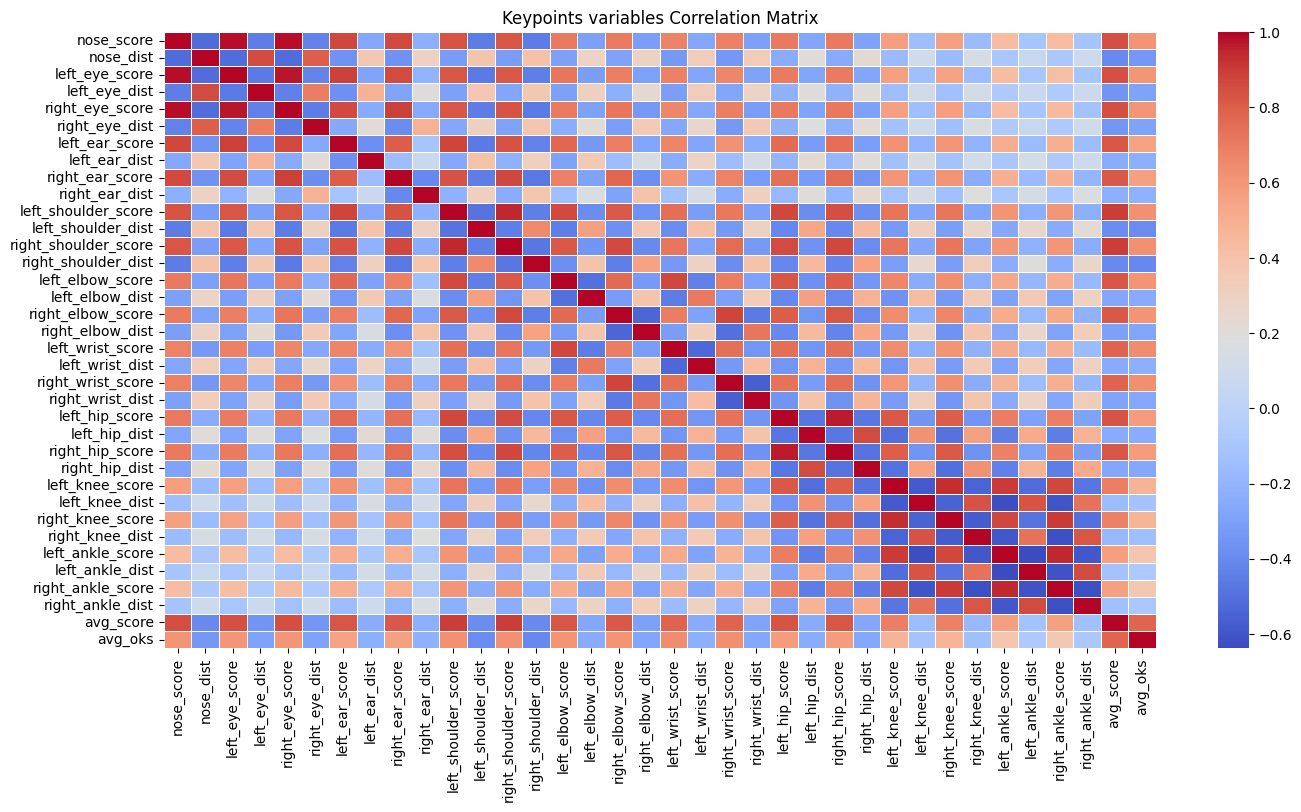

In [338]:
kp_corr_matrix = keypoints_df[[col for attr in coco_attrs_list for col in (f"{attr}_score", f"{attr}_dist")] + ['avg_score', 'avg_oks']].corr()
plt.figure(figsize=(16,8))
sns.heatmap(kp_corr_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot=False)
plt.title('Keypoints variables Correlation Matrix')
plt.show()

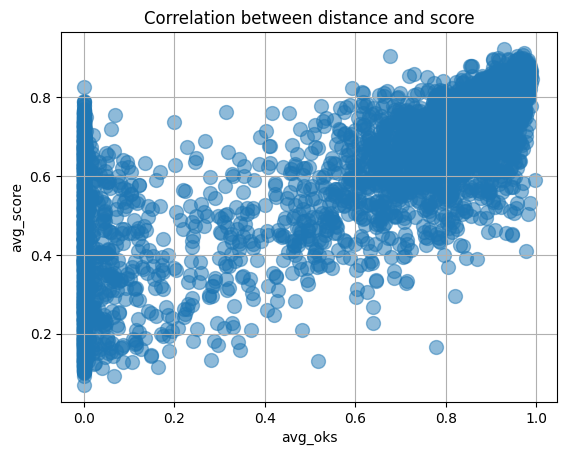

In [339]:
keypoints_df.plot(
    kind="scatter", 
    x='avg_oks', y='avg_score',
    s=100,       
    alpha=0.5    
)

plt.title("Correlation between distance and score")
plt.xlabel("avg_oks")
plt.ylabel("avg_score")        
plt.grid(True)            

plt.show()


In [340]:
float(keypoints_df['avg_oks'].corr(keypoints_df['avg_score']))

0.7807089116458092

### Boxplots by label

In [341]:
def plot_grouped_boxplot(df, feature, name=None, subplot=None):
    if not subplot:
        plt.figure(figsize=(8, 6))
        
    custom_palette = {
        'easy': 'yellow',
        'medium': 'orange',
        'hard': 'red',
        'very hard': 'purple'
    }

    label_order = ['easy', 'medium', 'hard', 'very hard']


    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=custom_palette, dodge=False, legend=False, order=label_order)
    if name:
        plt.title(f"Boxplot of {feature} by Label - {name}")
    else:
        plt.title(f"Boxplot of {feature} by Label")
    plt.xlabel("Label")
    plt.ylabel(f"{feature}")

    if not subplot:
        plt.show()

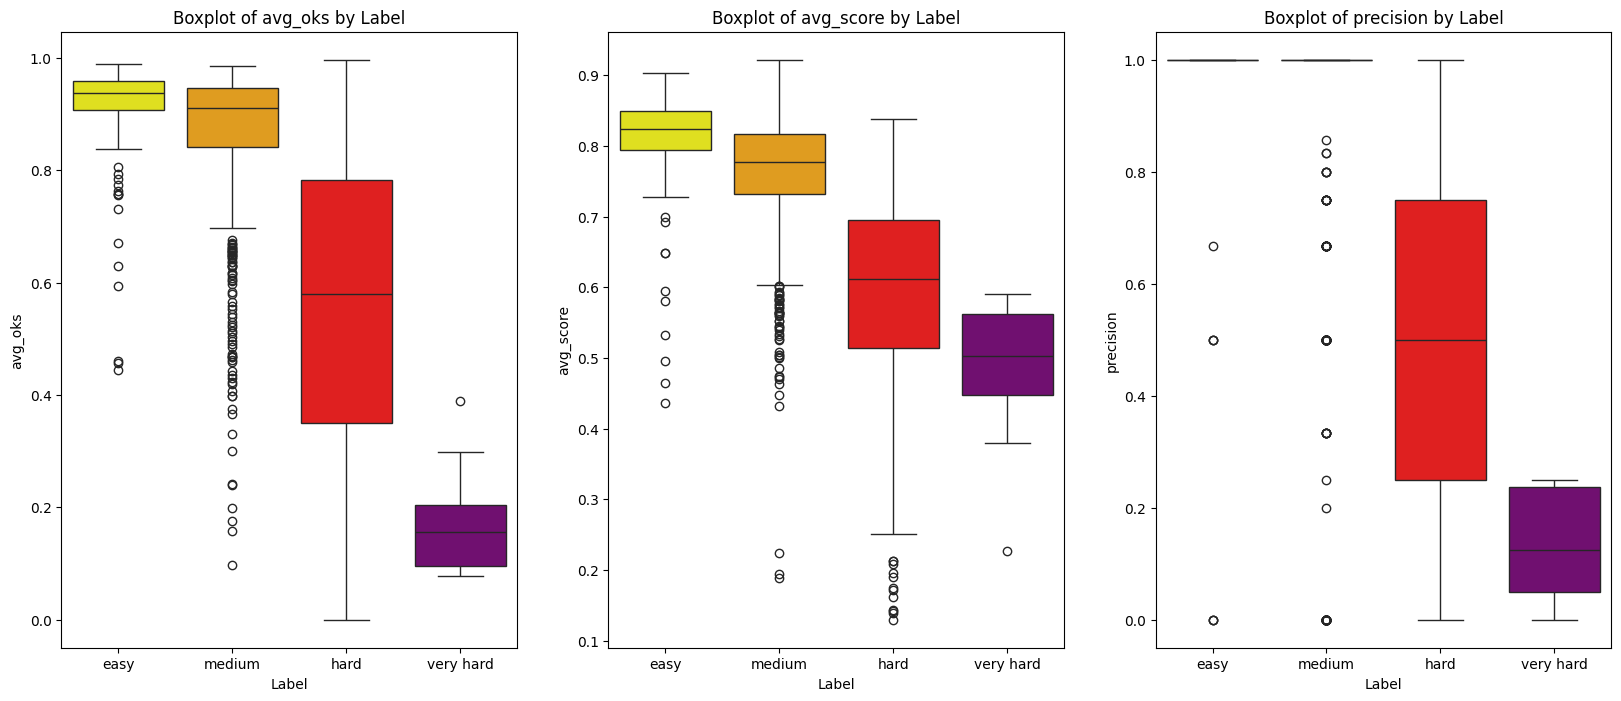

In [342]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plot_grouped_boxplot(img_keypoints_merged_df, 'avg_oks', subplot=True)
plt.subplot(1, 3, 2)
plot_grouped_boxplot(img_keypoints_merged_df, 'avg_score', subplot=True)
plt.subplot(1, 3, 3)
plot_grouped_boxplot(img_keypoints_merged_df, 'precision', subplot=True)
plt.show()

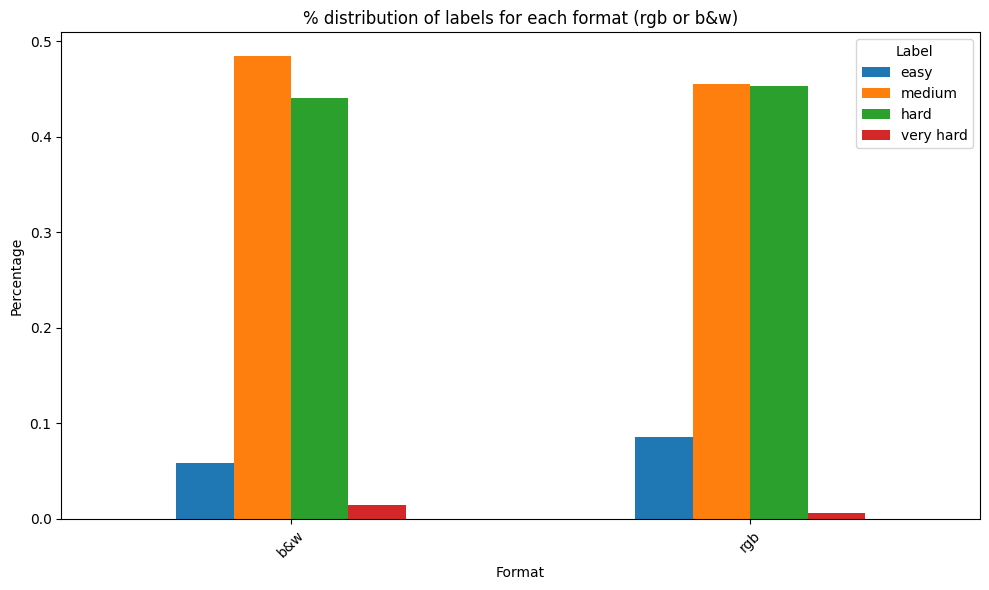

% distribution of labels for each format

label      easy    medium      hard  very hard
b&w    0.058824  0.485294  0.441176   0.014706
rgb    0.085395  0.455830  0.452886   0.005889

--------------------

Count of labels for each format

label   easy  hard  medium  very hard
Format                               
b&w        4    30      33          1
rgb      145   769     774         10


In [343]:
order_label = ['easy', 'medium', 'hard', 'very hard'] 
grouped_n = img_keypoints_merged_df.groupby('Format')['label'].value_counts(normalize=True).unstack(fill_value=0)
grouped = img_keypoints_merged_df.groupby('Format')['label'].value_counts().unstack(fill_value=0)

grouped_n.index = pd.Categorical(grouped_n.index, ordered=True)
grouped_n = grouped_n.sort_index()

grouped_n = grouped_n[order_label]

grouped_n.plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('% distribution of labels for each format (rgb or b&w)')
plt.xlabel('Format')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right')

plt.tight_layout()
plt.show()

print('% distribution of labels for each format')
print()
print(grouped_n)
print()
print('-'*20)
print()
print('Count of labels for each format')
print()
print(grouped)

### Boxplot of dist and score for each format

In [344]:
rgb_df = img_keypoints_merged_df[img_keypoints_merged_df['Format']=='rgb']
bew_df = img_keypoints_merged_df[img_keypoints_merged_df['Format']=='b&w']

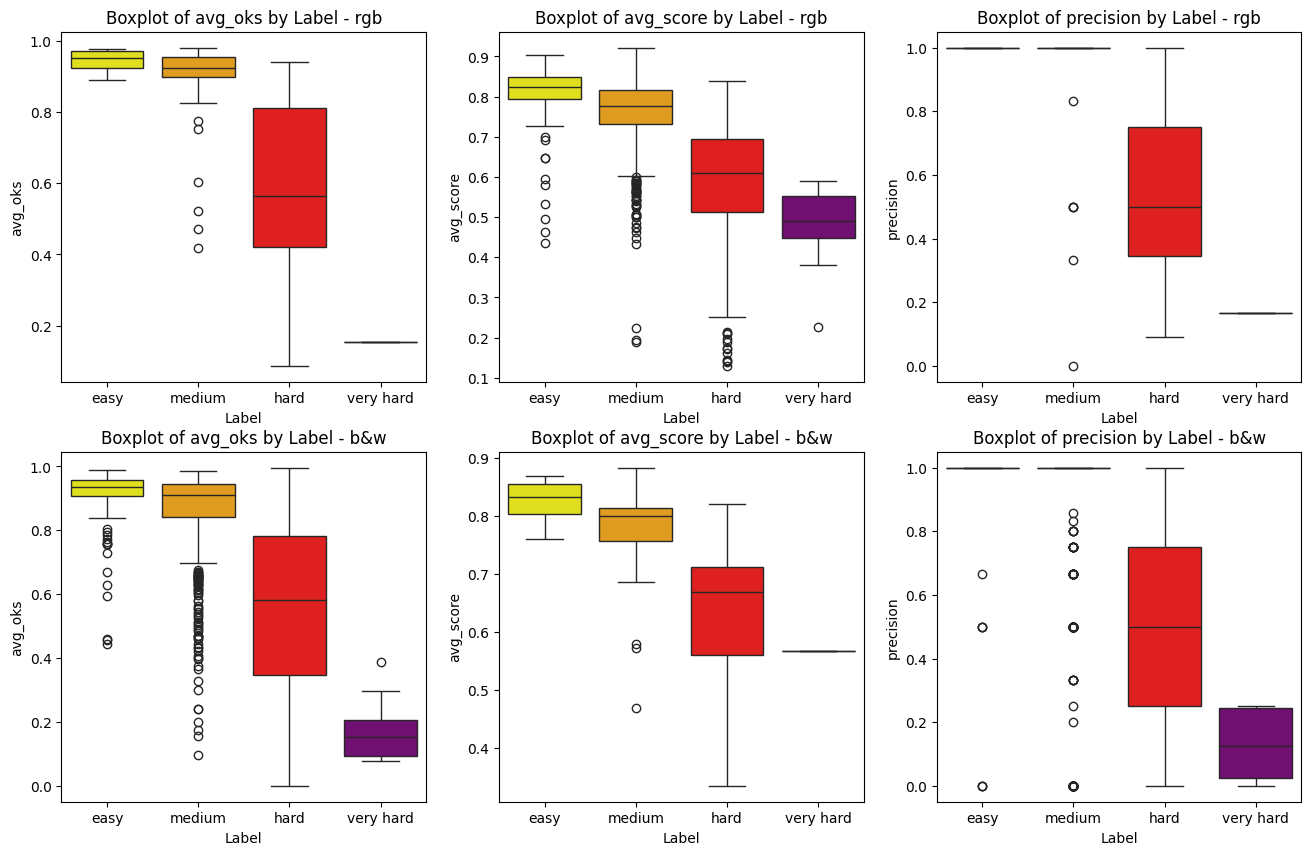

In [345]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plot_grouped_boxplot(bew_df, 'avg_oks', name='rgb', subplot=True)
plt.subplot(2, 3, 2)
plot_grouped_boxplot(rgb_df, 'avg_score', name='rgb', subplot=True)
plt.subplot(2, 3, 3)
plot_grouped_boxplot(bew_df, 'precision', name='rgb', subplot=True)
plt.subplot(2, 3, 4)
plot_grouped_boxplot(rgb_df, 'avg_oks', name='b&w', subplot=True)
plt.subplot(2, 3, 5)
plot_grouped_boxplot(bew_df, 'avg_score', name='b&w', subplot=True)
plt.subplot(2, 3, 6)
plot_grouped_boxplot(rgb_df, 'precision', name='b&w', subplot=True)
plt.show()

In [346]:
diff = ['people_size_diff', 'num_people_diff', 'visibility_diff', 'offset_diff', 'total_dif']

<Axes: >

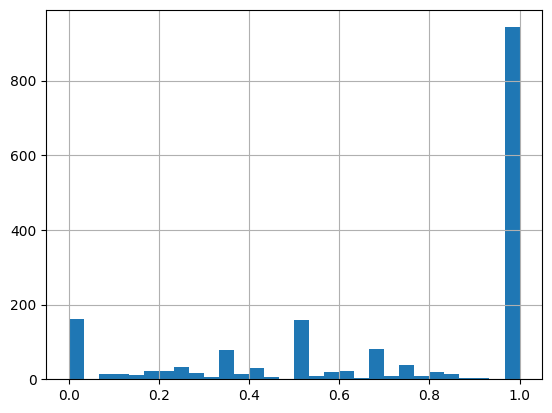

In [347]:
img_keypoints_merged_df['precision'].hist(bins=30)

In [355]:
precision_1 = img_keypoints_merged_df[img_keypoints_merged_df['precision'] == 1]
precision_0 = img_keypoints_merged_df[img_keypoints_merged_df['precision'] < 1]

In [356]:
def comparison_diff(ax, df1, df2, n1, n2, diff, color):
    df1[f'{diff}'].plot(kind='kde', color='blue', label=n1, ax=ax) 
    df2[f'{diff}'].plot(kind='kde', color=f'{color}', label=n2, ax=ax) 

    ax.set_xlabel(diff)
    ax.set_ylabel('Density') 
    ax.set_title(f'Density of {diff}')
    ax.legend()
    if diff != 'num_people_diff':
        ax.set_xlim(0, 1.1)

In [359]:
def add_category_distribution(ax, df1, df2, n1, n2, color):

    original_counts = df1['label'].value_counts(normalize=True)  
    precision_counts = df2['label'].value_counts(normalize=True)

    categories = ['easy', 'medium', 'hard']
    comparison_df = pd.DataFrame({
        n1: [original_counts.get(cat, 0) for cat in categories],
        n2: [precision_counts.get(cat, 0) for cat in categories]
    }, index=categories)

    comparison_df.plot(kind='bar', ax=ax, color=['blue', f'{color}'], width=0.4, position=1)

    ax.set_title('Category Distribution: Easy, Medium, Hard')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

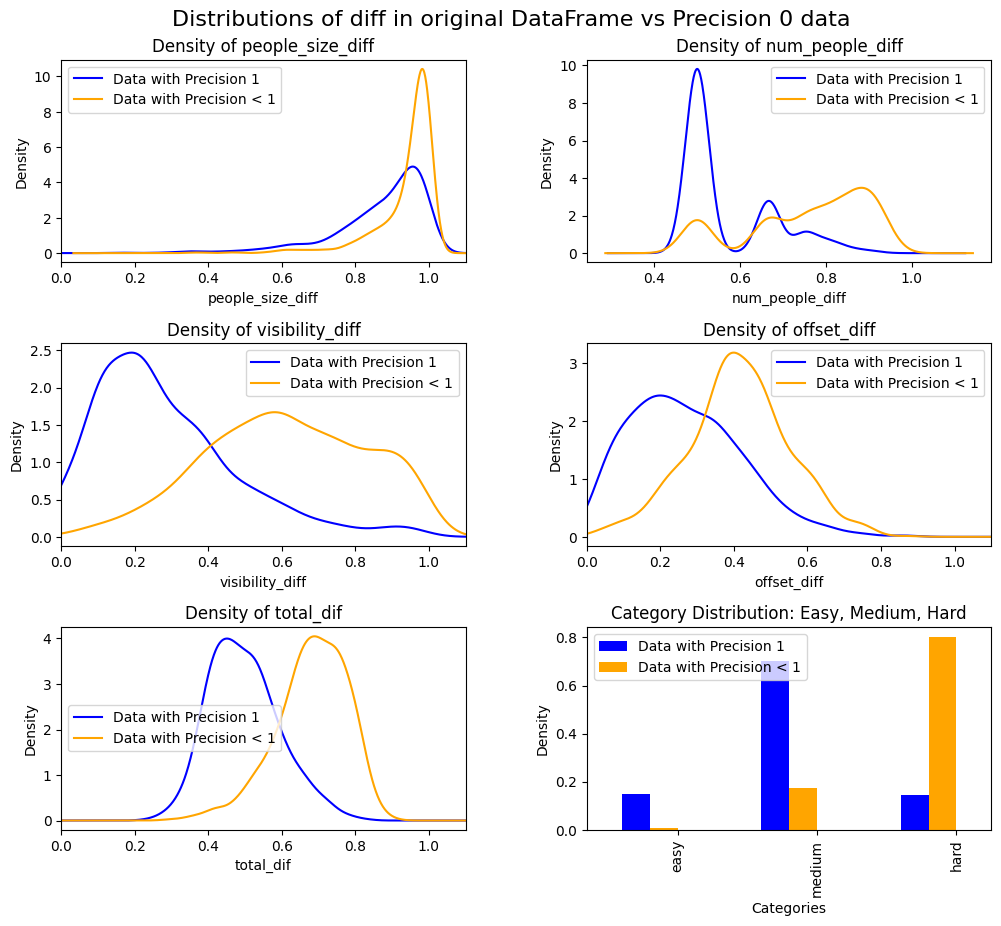

In [361]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 
fig.suptitle('Distributions of diff in original DataFrame vs Precision 0 data', fontsize=16, y=0.93)

for index, dif in enumerate(diff):
    ax = axes[index // 2, index % 2] 
    comparison_diff(ax, precision_1, precision_0, 'Data with Precision 1', 'Data with Precision < 1', dif, 'orange')

plt.subplots_adjust(hspace=0.3)  
ax = axes[-1, -1]  

add_category_distribution(ax, precision_1, precision_0, 'Data with Precision 1', 'Data with Precision < 1', 'orange')


plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()